In [1]:
import numpy as np
import pandas as pd
from scipy.stats.kde import gaussian_kde
from scipy.stats import norm
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as grid_spec

import arviz as az
import scipy.stats as st

from sklearn.neighbors import KernelDensity

In [2]:
def get_hdi(kde, x_d, hdi_prob=0.95):
    
    logprob = kde.score_samples(x_d[:, None])
    probs = np.exp(logprob)
    
    # Sort probabilities and x_d by probability
    sorted_indices = np.argsort(probs)[::-1]
    sorted_probs = probs[sorted_indices]
    sorted_x_d = x_d[sorted_indices]
    
    # Cumulative sum to find HDI
    cumulative_probs = np.cumsum(sorted_probs)
    hdi_index = cumulative_probs <= hdi_prob * cumulative_probs[-1]
    hdi_x = sorted_x_d[hdi_index]
    
    return hdi_x.min(), hdi_x.max()

In [2]:
bootstrap_data = pd.read_csv("data/bootstrap_data_soc.csv")
bootstrap_data

,obj,β01,β02,β03,β04,β05,β06,β07,β08,β09,β10,σ,σ1,σ2,ρ1,θ1,θ2,θ3
0,1833.457069,2.253439,-0.085886,0.031558,-0.304764,0.092666,-0.004955,0.008369,-0.008925,0.001979,-0.020561,0.257310,0.159313,0.292812,-0.435786,0.619148,-0.495912,1.024232
1,1800.275464,2.151446,-0.079526,0.032153,-0.293835,0.142138,-0.002144,0.006747,-0.009127,0.002133,-0.019277,0.256856,0.199867,0.279502,-0.583953,0.778128,-0.635438,0.883360
2,1777.575975,2.151913,-0.068269,0.035347,-0.264008,0.134485,-0.001816,0.007776,-0.009102,0.001790,-0.022715,0.256633,0.201328,0.299536,-0.683559,0.784498,-0.797834,0.851916
3,1809.667604,2.235346,-0.091369,0.035772,-0.268482,0.090017,-0.000425,0.006818,-0.008697,0.002268,-0.019960,0.257344,0.161920,0.270727,-0.691257,0.629199,-0.727207,0.760189
4,1832.247019,2.226645,-0.090022,0.038083,-0.356252,0.111899,0.000915,0.006308,-0.008828,0.002756,-0.020540,0.257043,0.210930,0.340542,-0.670438,0.820600,-0.888224,0.982988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1939.928223,2.120593,-0.087694,0.024621,-0.292832,0.135325,-0.000499,0.007254,-0.008971,0.002316,-0.020267,0.258740,0.177058,0.232696,-0.566010,0.684309,-0.509037,0.741416
9996,2083.810871,2.128469,-0.092005,0.038847,-0.323461,0.138006,-0.000144,0.004237,-0.008987,0.002737,-0.014915,0.260169,0.203505,0.273418,-0.673908,0.782201,-0.708225,0.776438
9997,1941.117137,2.253999,-0.083765,0.034226,-0.279576,0.091752,-0.000993,0.005623,-0.009088,0.003091,-0.016816,0.258725,0.207907,0.275461,-0.793018,0.803581,-0.844315,0.648605
9998,1794.779077,2.298708,-0.084896,0.023952,-0.270372,0.040207,0.000243,0.007039,-0.008774,0.001870,-0.019967,0.256564,0.212439,0.303619,-0.488451,0.828017,-0.578036,1.032630


# Idealized KDEs

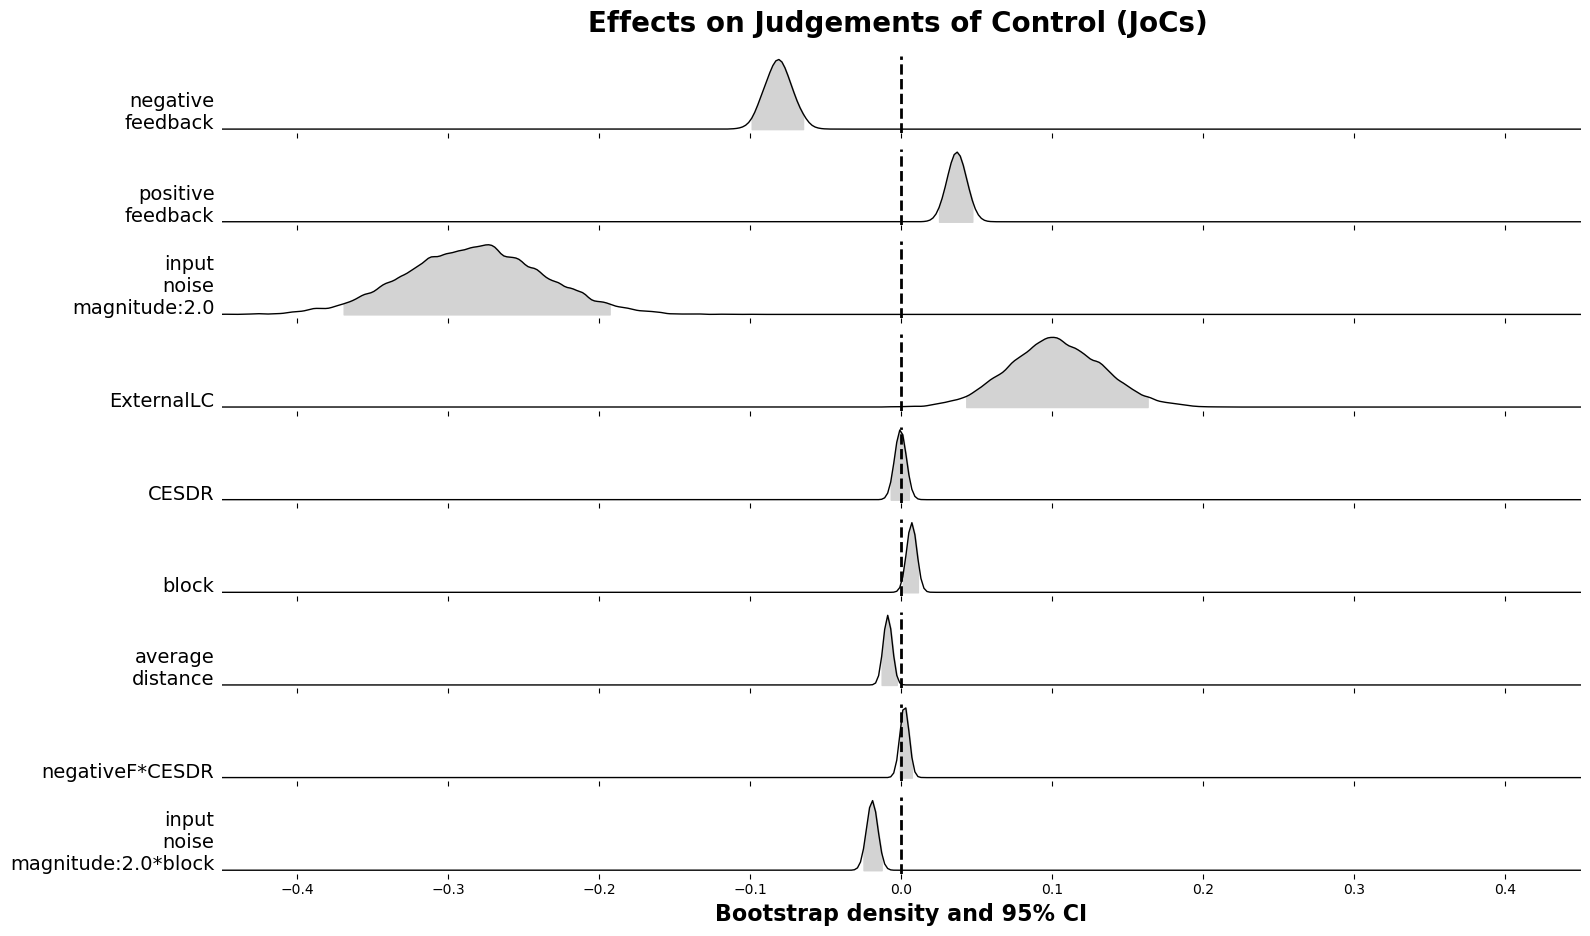

In [6]:
beta_labels = ['β02', 'β03', 'β04', 'β05', 'β06', 'β07', 'β08', 'β09', 'β10']
covariates = ["negative feedback", "positive feedback", "input noise magnitude:2.0", "ExternalLC", "CESDR", "block", "average distance", "negativeF*CESDR", "input noise magnitude:2.0*block"]

gs = grid_spec.GridSpec(len(beta_labels),1)
fig = plt.figure(figsize=(16,9))

i = 0

ax_objs = []
for beta_label, covariate in zip(beta_labels, covariates):
    x = np.array(bootstrap_data[f"{beta_label}"])
    x_d = np.linspace(-1,1, 1000)

    kde = KernelDensity(bandwidth=0.003, kernel='gaussian')  # unidealized: bandwidth=0.001
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])
    
    # get 95%HDI bounds
    hdi_min, hdi_max = get_hdi(kde, x_d, hdi_prob=0.95)

    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob),color="black",lw=1)
    #ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1,color="lightgrey")
    ax_objs[-1].fill_between(
        x_d, np.exp(logprob), where=(x_d >= hdi_min) & (x_d <= hdi_max),
        alpha=1, color="lightgrey")


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.45,0.45)
    #ax_objs[-1].set_ylim(0,13.3)
    
    ax_objs[-1].axvline(x=0, color='black', linestyle='dashed', lw=2)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticks([])

    if i == len(beta_labels)-1:
        ax_objs[-1].set_xlabel("Bootstrap density and 95% CI", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_covariate = covariate.replace(" ","\n")
    ax_objs[-1].text(-0.455,0,adj_covariate,fontweight="normal",fontsize=14,ha="right")


    i += 1

#gs.update(hspace=-0.7)

fig.text(0.37, 1.01, "Effects on Judgements of Control (JoCs)", fontsize=20, fontweight="bold")
#plt.title('Center Title', fontsize=16,fontweight="bold")

plt.tight_layout()
plt.show()

In [3]:
bootstrap_data_performance = pd.read_csv("data/bootstrap_data_performance.csv")
bootstrap_data_performance

,obj,β1,β2,β3,β4,σ,σ1,σ2,ρ1,θ1,θ2,θ3
0,1317.413863,3.226260,0.593552,-0.019213,0.009826,0.252644,0.190333,0.131077,-0.814364,0.753364,-0.422510,0.301101
1,1282.170846,3.263855,0.578891,-0.020681,0.011183,0.252201,0.229551,0.145971,-0.893817,0.910191,-0.517331,0.259547
2,1262.311324,3.255232,0.603226,-0.019689,0.007806,0.252011,0.232231,0.159272,-0.919125,0.921511,-0.580888,0.248987
3,1294.841198,3.267289,0.588219,-0.020747,0.010539,0.252704,0.186359,0.132826,-0.906625,0.737460,-0.476541,0.221778
4,1308.557314,3.329269,0.543413,-0.021256,0.009979,0.252388,0.240639,0.170365,-0.912704,0.953448,-0.616086,0.275824
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1425.968982,3.233392,0.596706,-0.020242,0.010188,0.254082,0.209102,0.130509,-0.914045,0.822973,-0.469499,0.208342
9996,1559.755314,3.257348,0.561650,-0.023277,0.015424,0.255458,0.235550,0.143653,-0.931615,0.922069,-0.523879,0.204379
9997,1418.145598,3.278036,0.571816,-0.021879,0.013411,0.254099,0.238827,0.158633,-0.968376,0.939896,-0.604551,0.155758
9998,1276.243383,3.221538,0.601228,-0.020478,0.010498,0.251960,0.248564,0.149033,-0.875330,0.986521,-0.517751,0.286002


/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_11709/4093053198.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


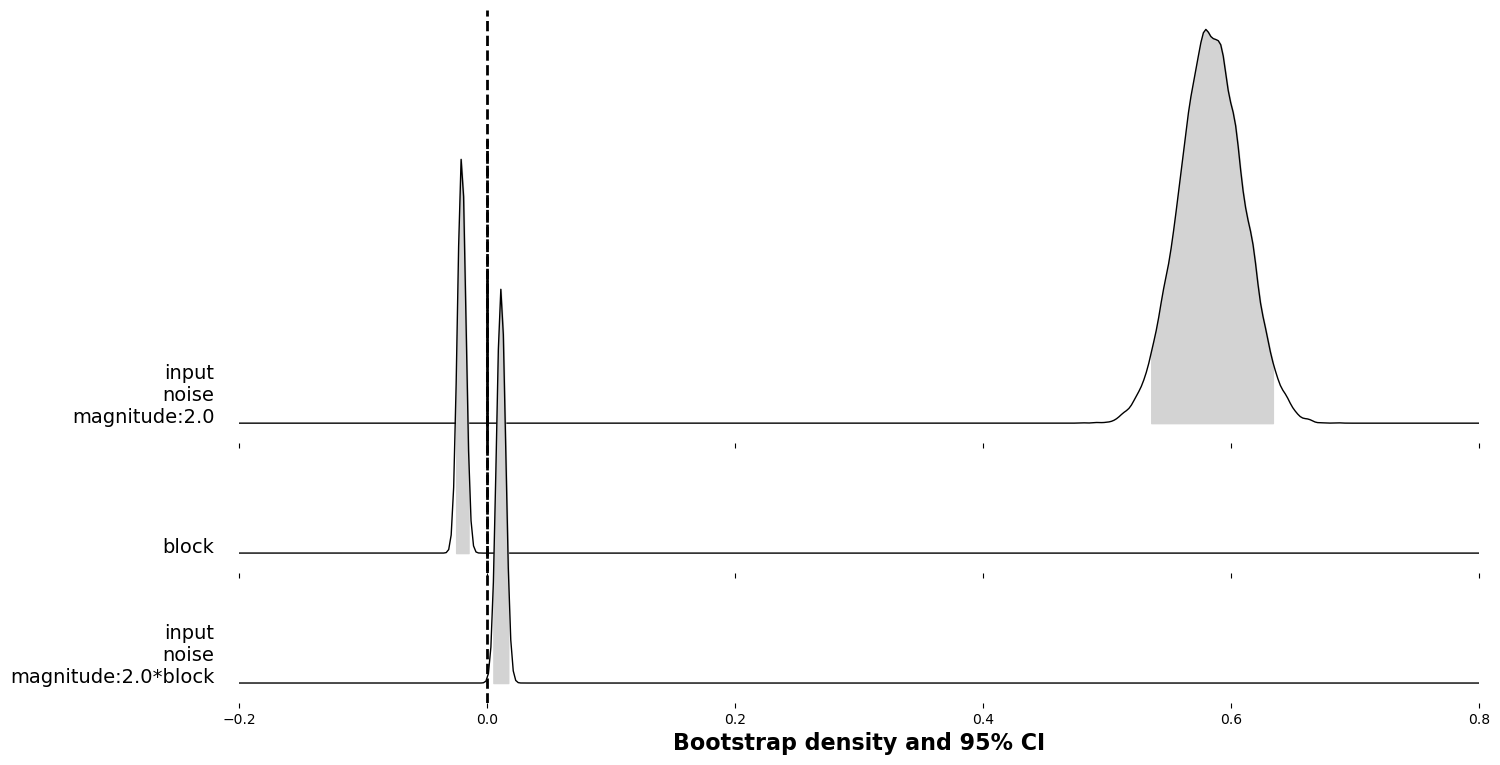

In [8]:
beta_labels = ['β2', 'β3', 'β4']
covariates = ["input noise magnitude:2.0", "block", "input noise magnitude:2.0*block"]

gs = grid_spec.GridSpec(len(beta_labels),1)
fig = plt.figure(figsize=(16,9))

i = 0

ax_objs = []
for beta_label, covariate in zip(beta_labels, covariates):
    x = np.array(bootstrap_data_performance[f"{beta_label}"])
    x_d = np.linspace(-1,1, 1000)

    kde = KernelDensity(bandwidth=0.003, kernel='gaussian')
    kde.fit(x[:, None])

    logprob = kde.score_samples(x_d[:, None])
    
    # get 95%HDI bounds
    hdi_min, hdi_max = get_hdi(kde, x_d, hdi_prob=0.95)
    
    # creating new axes object
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))

    # plotting the distribution
    ax_objs[-1].plot(x_d, np.exp(logprob), color="black", lw=1)
    #ax_objs[-1].fill_between(x_d, np.exp(logprob), alpha=1, color="lightgrey")
    ax_objs[-1].fill_between(
        x_d, np.exp(logprob), where=(x_d >= hdi_min) & (x_d <= hdi_max),
        alpha=1, color="lightgrey")


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.2,0.8)
    #if i == 0:
    #    ax_objs[-1].set_ylim(0,10.3)
    #else:
    #    ax_objs[-1].set_ylim(0,13.3)
    
    ax_objs[-1].axvline(x=0, color='black', linestyle='dashed', lw=2)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticks([])

    if i == len(beta_labels)-1:
        ax_objs[-1].set_xlabel("Bootstrap density and 95% CI", fontsize=16, fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_covariate = covariate.replace(" ", "\n")
    ax_objs[-1].text(-0.22,0, adj_covariate, fontweight="normal", fontsize=14, ha="right")


    i += 1

gs.update(hspace=-0.7)

#fig.text(0.07,0.85,"...",fontsize=20)

plt.tight_layout()
plt.show()

# Unidealized KDEs

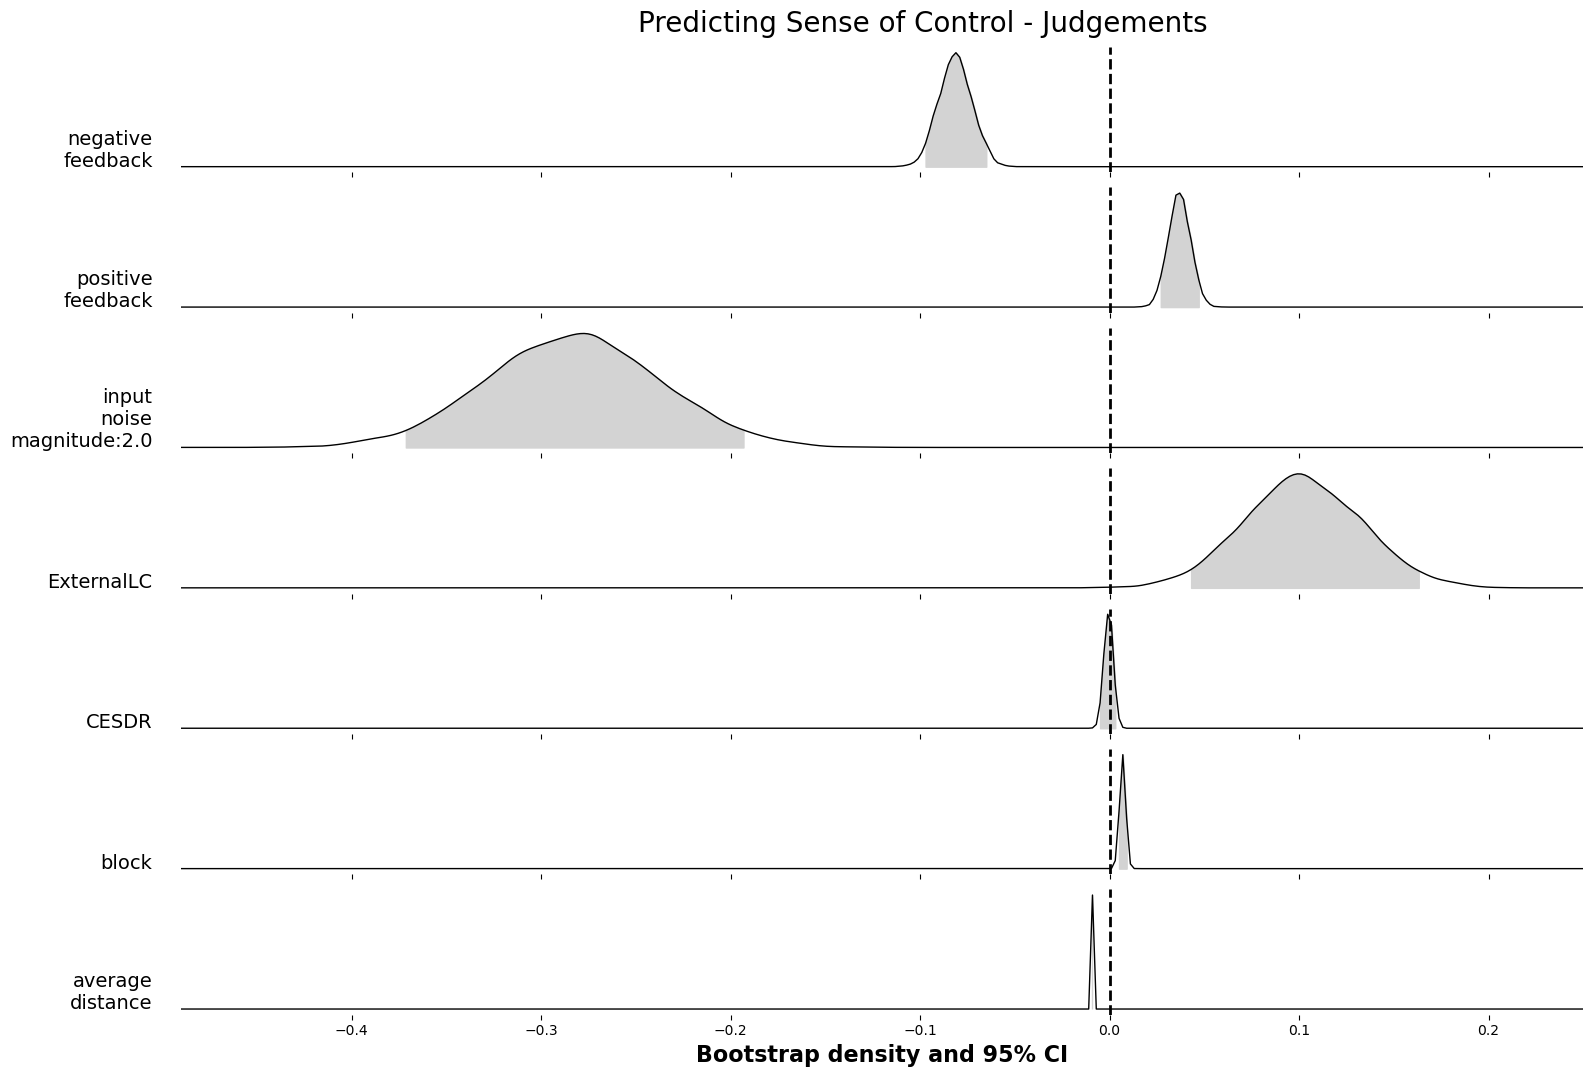

In [5]:
bootstrap_data = pd.read_csv("data/bootstrap_data_soc.csv")

beta_labels = ['β02', 'β03', 'β04', 'β05', 'β06', 'β07', 'β08']
covariates = ["negative feedback", "positive feedback", "input noise magnitude:2.0", "ExternalLC", "CESDR", "block", "average distance"]

gs = grid_spec.GridSpec(len(beta_labels),1)
fig = plt.figure(figsize=(16,10.5))

i = 0

ax_objs = []
for beta_label, covariate in zip(beta_labels, covariates):
    x = np.array(bootstrap_data[f"{beta_label}"])
    
    hpdi_bounds = az.hdi(x, 0.95)
    x_d = np.linspace(-1,1, 1000)
    kde = st.gaussian_kde(x)
    
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    
    ax_objs[-1].plot(x_d, kde(x_d), color="black", lw=1)
    ax_objs[-1].fill_between(x_d, kde(x_d), 
                             where=(x_d >= hpdi_bounds[0]) & (x_d <= hpdi_bounds[1]), 
                             alpha=1, color="lightgrey")


    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.49,0.25)
    #ax_objs[-1].set_ylim(0,13.3)
    
    ax_objs[-1].axvline(x=0, color='black', linestyle='dashed', lw=2)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticks([])

    if i == len(beta_labels)-1:
        ax_objs[-1].set_xlabel("Bootstrap density and 95% CI", fontsize=16,fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_covariate = covariate.replace(" ","\n")
    ax_objs[-1].text(-0.505,0,adj_covariate,fontweight="normal",fontsize=14,ha="right")


    i += 1

#gs.update(hspace=-0.7) # overlap

# title
fig.text(0.4, 1.0,"Predicting Sense of Control - Judgements",fontsize=20)

plt.tight_layout()
plt.savefig("SoCs_CIs.svg", dpi=2000)

plt.show()

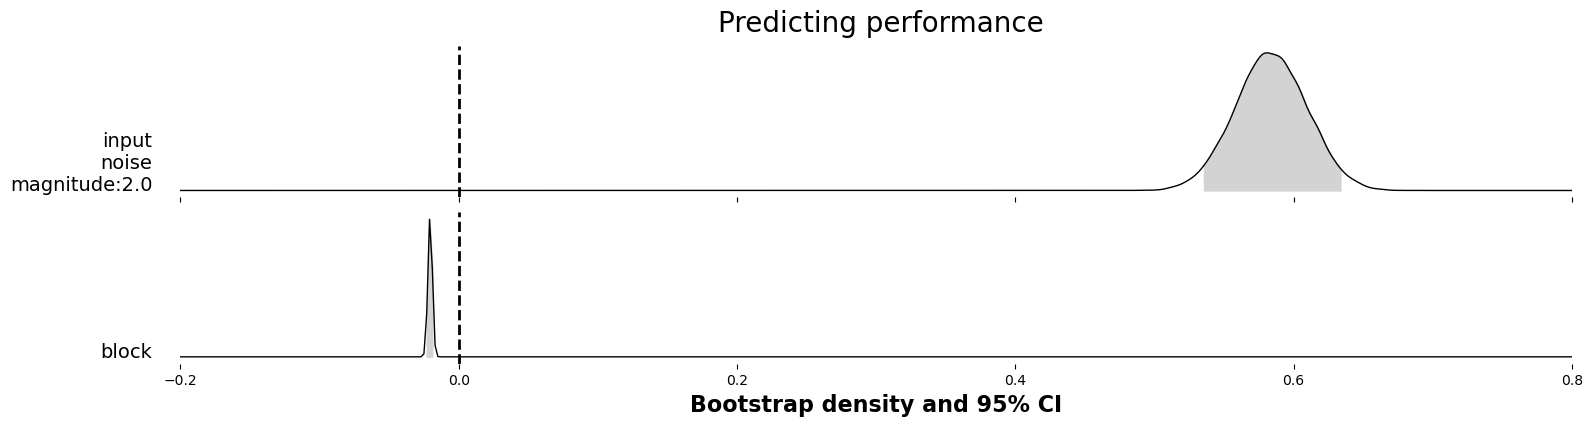

In [6]:
bootstrap_data_performance = pd.read_csv("data/bootstrap_data_performance.csv")

beta_labels = ['β2', 'β3']
covariates = ["input noise magnitude:2.0", "block",]

gs = grid_spec.GridSpec(len(beta_labels),1)
fig = plt.figure(figsize=(16,4))

i = 0

ax_objs = []
for beta_label, covariate in zip(beta_labels, covariates):
    x = np.array(bootstrap_data_performance[f"{beta_label}"])
    
    hpdi_bounds = az.hdi(x, 0.95)
    x_d = np.linspace(-1,1, 1000)
    kde = st.gaussian_kde(x)
    
    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    
    ax_objs[-1].plot(x_d, kde(x_d), color="black", lw=1)
    ax_objs[-1].fill_between(x_d, kde(x_d), 
                             where=(x_d >= hpdi_bounds[0]) & (x_d <= hpdi_bounds[1]), 
                             alpha=1, color="lightgrey")

    # setting uniform x and y lims
    ax_objs[-1].set_xlim(-0.2,0.8)
    #ax_objs[-1].set_ylim(0,15.3)
    
    ax_objs[-1].axvline(x=0, color='black', linestyle='dashed', lw=2)

    # make background transparent
    rect = ax_objs[-1].patch
    rect.set_alpha(0)

    # remove borders, axis ticks, and labels
    ax_objs[-1].set_yticks([])

    if i == len(beta_labels)-1:
        ax_objs[-1].set_xlabel("Bootstrap density and 95% CI", fontsize=16, fontweight="bold")
    else:
        ax_objs[-1].set_xticklabels([])

    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)

    adj_covariate = covariate.replace(" ", "\n")
    ax_objs[-1].text(-0.22,0, adj_covariate, fontweight="normal", fontsize=14, ha="right")

    i += 1

#gs.update(hspace=-0.7)

# title
fig.text(0.45, 1.0,"Predicting performance",fontsize=20)

plt.tight_layout()
plt.savefig("performance_CIs.svg", dpi=2000)

plt.show()